In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def segment_rabbits(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to RGB (OpenCV loads as BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV color space
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    lower_beige = np.array([15, 30, 150])
    upper_beige = np.array([100, 200, 240])

    # Create a mask for beige/cream colors
    mask = cv2.inRange(img_hsv, lower_beige, upper_beige)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Apply the mask to get only the rabbits
    rabbits_only = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    # Display results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title('HSV Image')
    plt.imshow(img_hsv)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title('Segmented Rabbits')
    plt.imshow(rabbits_only)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return mask, rabbits_only

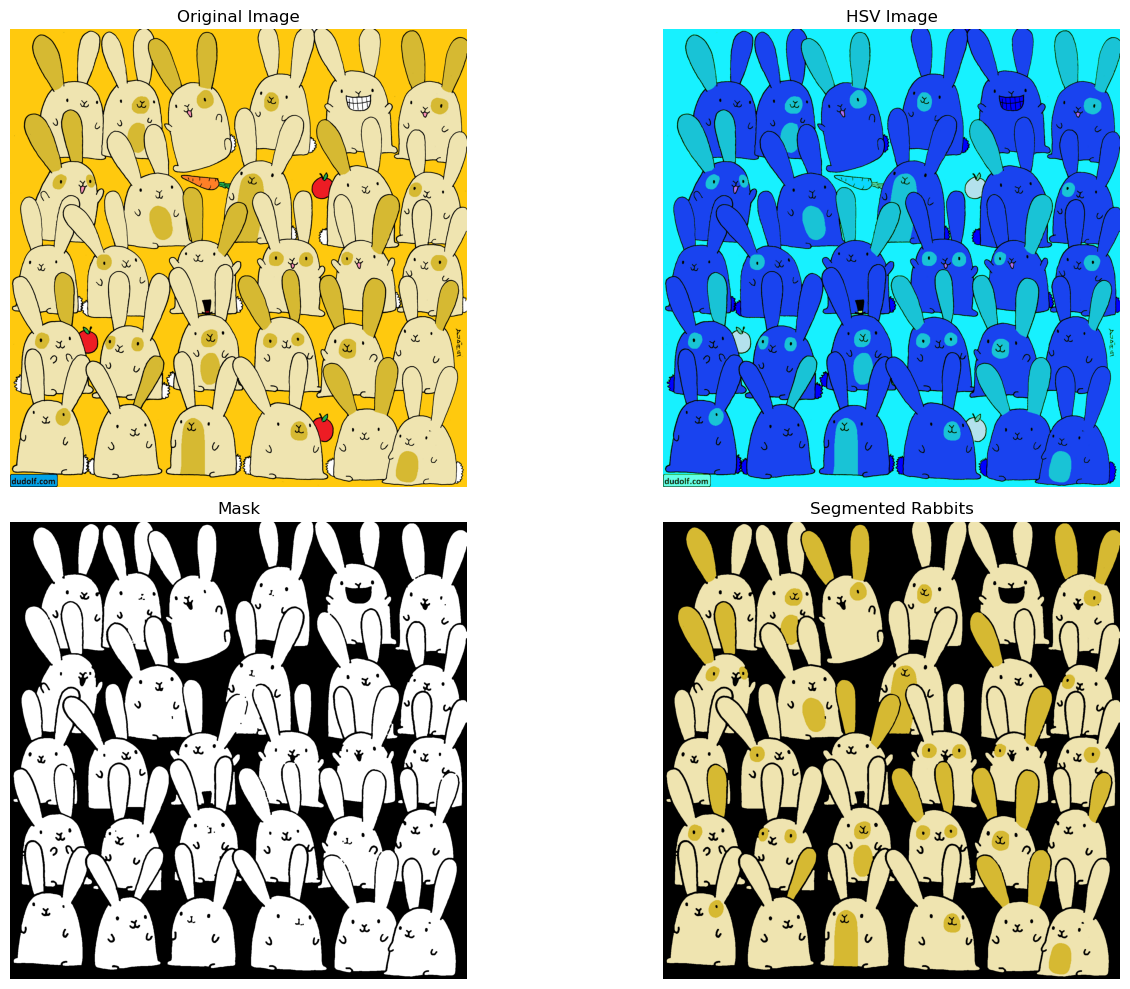

In [ ]:
mask, rabbits_only = segment_rabbits('/content/rabbit2.png')

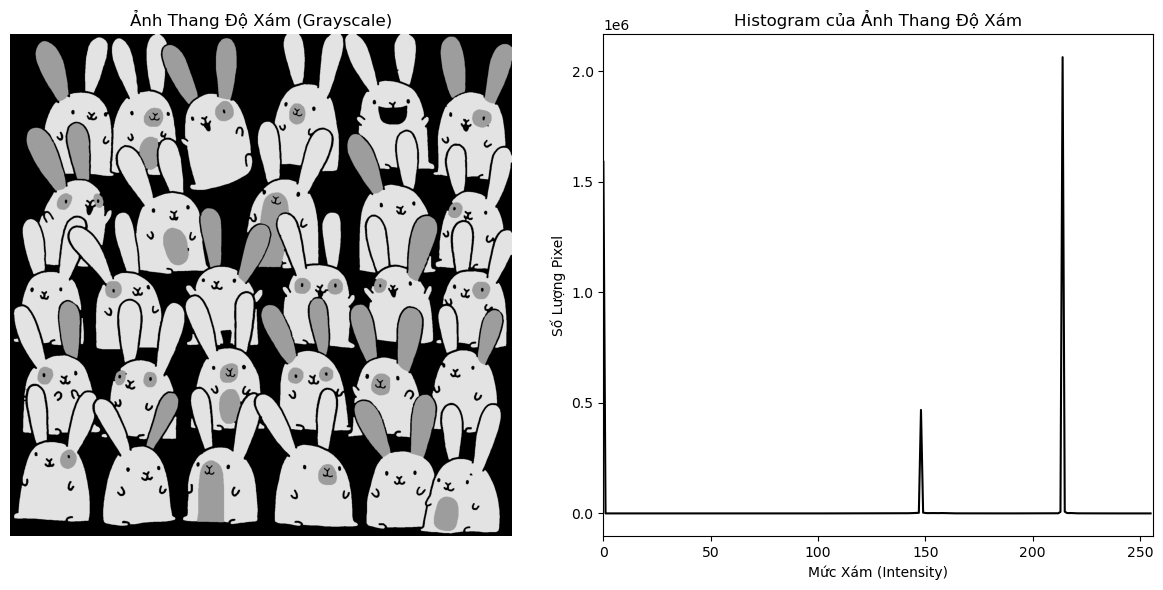

In [ ]:
gray_image = cv2.cvtColor(rabbits_only, cv2.COLOR_BGR2GRAY)

histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

# Display results
plt.figure(figsize=(12, 6)) 

# Show gray scale
plt.subplot(1, 2, 1) 
plt.imshow(gray_image, cmap='gray')
plt.title('Ảnh Thang Độ Xám (Grayscale)')
plt.axis('off')

# Histogram display
plt.subplot(1, 2, 2) 
plt.plot(histogram, color='black')
plt.title('Histogram của Ảnh Thang Độ Xám')
plt.xlabel('Mức Xám (Intensity)')
plt.ylabel('Số Lượng Pixel')
plt.xlim([0, 256]) 

plt.tight_layout() 
plt.show()



Đã áp dụng Gaussian Blur với kernel (5, 5)


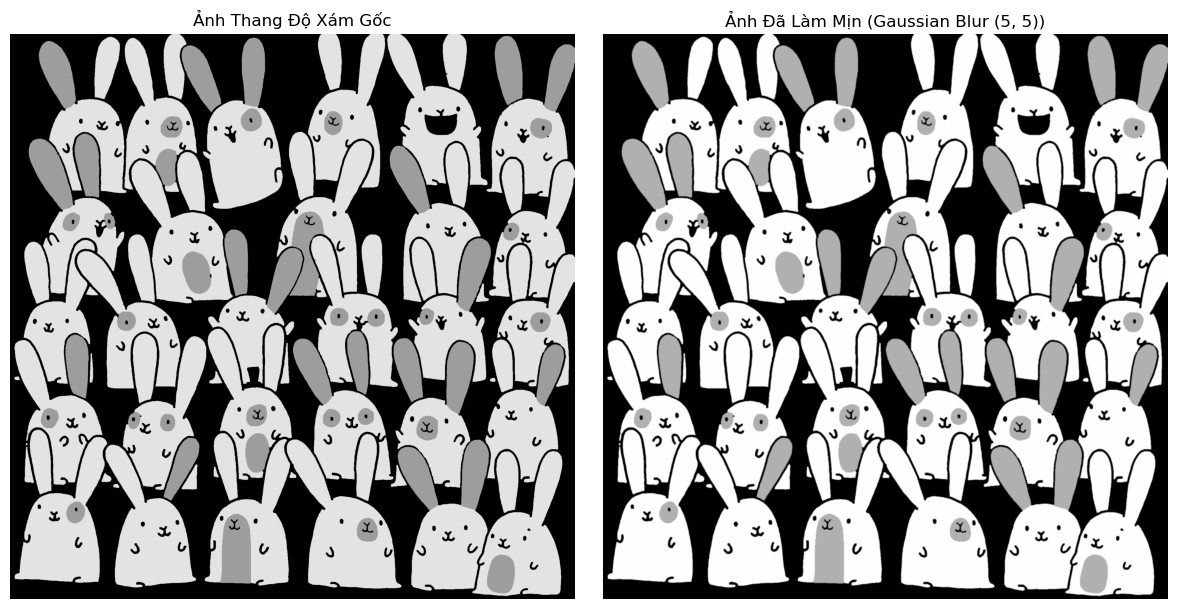

In [ ]:
GAUSSIAN_KERNEL_SIZE = (5, 5)

blurred_gray_image = cv2.GaussianBlur(gray_image, GAUSSIAN_KERNEL_SIZE, 0)

print(f"Đã áp dụng Gaussian Blur với kernel {GAUSSIAN_KERNEL_SIZE}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Ảnh Thang Độ Xám Gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred_gray_image, cmap='gray')
plt.title(f'Ảnh Đã Làm Mịn (Gaussian Blur {GAUSSIAN_KERNEL_SIZE})')
plt.axis('off')

plt.tight_layout()
plt.show()


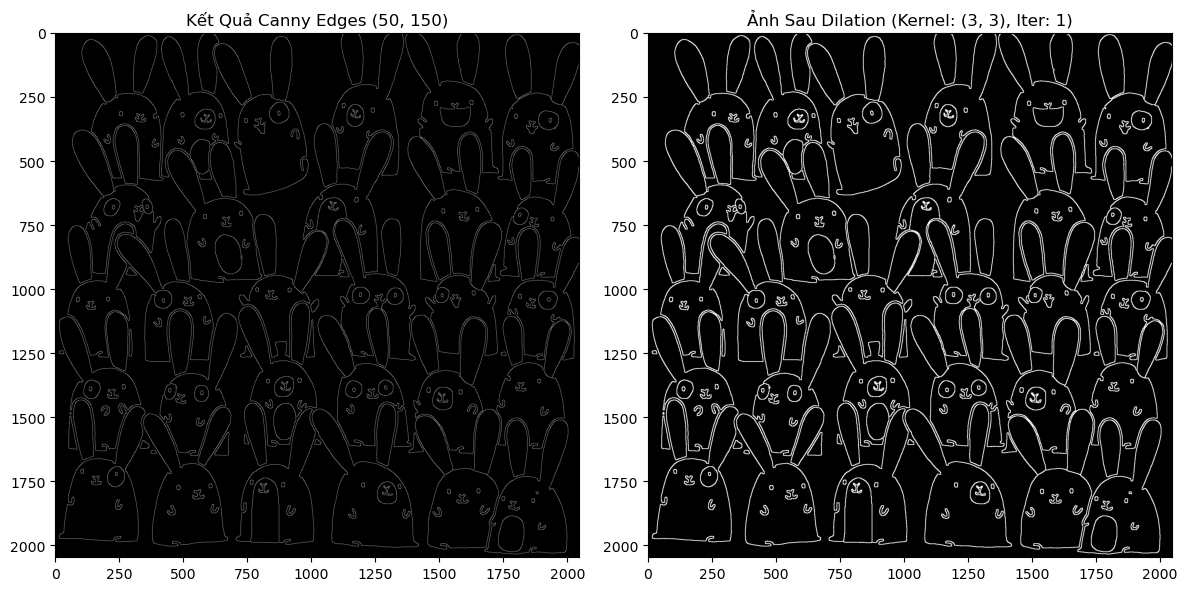

In [ ]:
CANNY_THRESHOLD_1 = 50
CANNY_THRESHOLD_2 = 150

# Using Canny Edge Detection
canny_edges = cv2.Canny(blurred_gray_image, CANNY_THRESHOLD_1, CANNY_THRESHOLD_2)

# Perform dilation to highlight the border
DILATION_KERNEL_SIZE = (3, 3)  
DILATION_ITERATIONS = 1  

kernel = np.ones(DILATION_KERNEL_SIZE, np.uint8)
dilated_edges = cv2.dilate(canny_edges, kernel, iterations=DILATION_ITERATIONS)

# Show the results of Canny and photos after dilation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(canny_edges, cmap='gray')
plt.title(f'Kết Quả Canny Edges ({CANNY_THRESHOLD_1}, {CANNY_THRESHOLD_2})')
plt.axis('on')

plt.subplot(1, 2, 2)
plt.imshow(dilated_edges, cmap='gray')
plt.title(f'Ảnh Sau Dilation (Kernel: {DILATION_KERNEL_SIZE}, Iter: {DILATION_ITERATIONS})')
plt.axis('on')

plt.tight_layout()
plt.show()


In [ ]:
def count_rabbits(image):
    
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    
    binary_inv = cv2.bitwise_not(binary)

    contours, hierarchy = cv2.findContours(binary_inv, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    rabbit_count = 0
    if hierarchy is not None: 
        for i, contour in enumerate(contours):
            if hierarchy[0][i][3] == -1: 

                # Calculate the area and circumference of Contour
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)

                # Calculate the frame ratio
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = h / w if w > 0 else 0

                if 25000 < area < 120000 and 0.8 < aspect_ratio < 3.0:

                    # Convexity defects check
                    hull = cv2.convexHull(contour, returnPoints=False)
                    if hull is not None and len(hull) > 3:
                        defects = cv2.convexityDefects(contour, hull)
                        significant_defects = sum(1 for defect in defects if defect[0][3] > 500) if defects is not None else 0

                        if significant_defects <= 9:
                            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)
                            cv2.putText(output_image, str(rabbit_count+1), (x+10, y+h//2),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                            rabbit_count += 1

    # Show results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Đã đếm được {rabbit_count} thỏ")
    plt.axis('off')
    plt.show()

    return rabbit_count, output_image


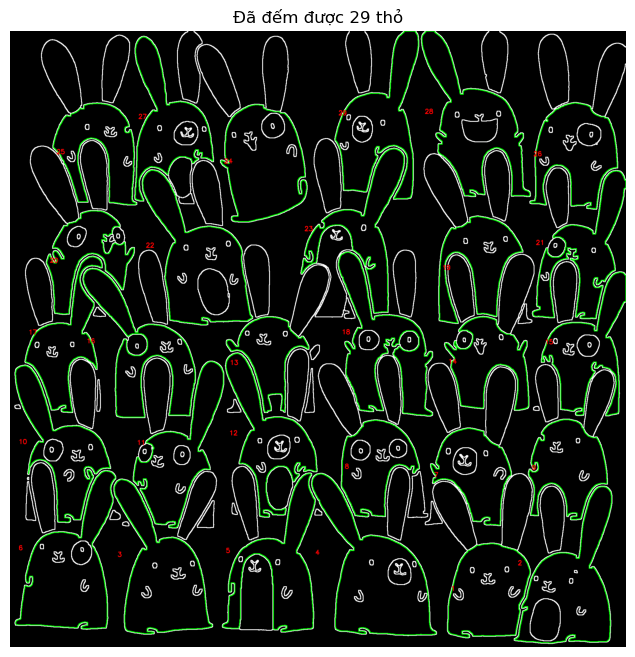

Số thỏ được phát hiện: 29


In [11]:
result, output_img = count_rabbits(dilated_edges)
print(f"Số thỏ được phát hiện: {result}")

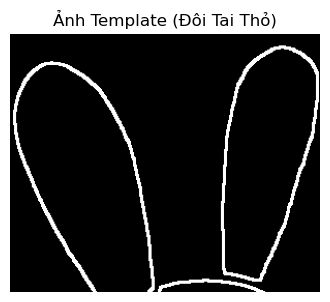

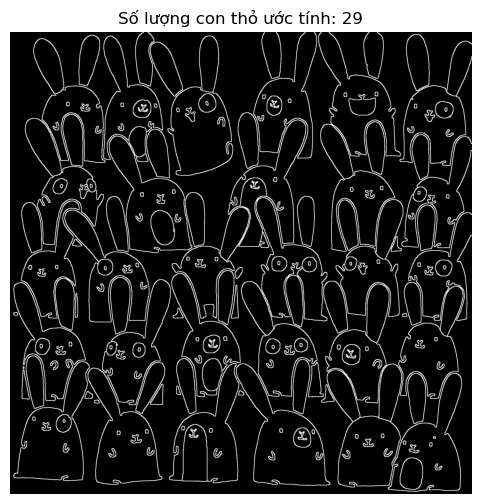

In [ ]:

_, thresh = cv2.threshold(dilated_edges, 128, 255, cv2.THRESH_BINARY)

template = thresh[0:250, 100:400]

plt.figure(figsize=(4, 4))
plt.imshow(template, cmap="gray")
plt.title("Ảnh Template (Đôi Tai Thỏ)")
plt.axis("off")
plt.show()

result = cv2.matchTemplate(thresh, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.333
locations = np.where(result >= threshold)
matched_points = list(zip(*locations[::-1]))

# Number of rabbits = the number of ears found
num_rabbits = len(matched_points)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(thresh, cmap="gray")
for pt in matched_points
    cv2.rectangle(thresh, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (255, 0, 0), 2)


ax.set_title(f"Số lượng con thỏ ước tính: {num_rabbits}")
plt.show()
